# Cell nuclei segmentation
Image segmentation is basically the process of assigning a label to every pixel in an image such that pixels with the same label share the same characteristics.

The objective of this project is to automatically segment any medical image containing cell nuclei by assigning a value of 1 to the cell nuclei and 0 to the rest. For this purpose, a deep learning model will be trained with a large number of medical images containing cell nuclei.

Dataset from https://www.kaggle.com/c/data-science-bowl-2018/data

Zhouxiang Guo

# Create paths for training images and masks
The first step is to get the full path of the training data, medical images and their respective masks which contain the labels of the medical images.

In [4]:
import os
import numpy as np
import pandas as pd
# %matplotlib inline so matplotlib can show images within  notebook
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

In [5]:
training_data_folder_path = 'data-science-bowl-2018/stage1_train'
training_data_subfolders_paths = os.listdir(training_data_folder_path)

training_data_images_full_path_image = []
training_data_images_full_path_mask = []
for i in range(len(os.listdir(training_data_folder_path))):
    final_image_path = os.listdir(training_data_folder_path 
                                  + "/" + 
                                  training_data_subfolders_paths[i] 
                                  + "/" + 
                                  "images")[0]
    training_data_images_full_path_image.append(training_data_folder_path + 
                                                "/" +
                                                training_data_subfolders_paths[i] +
                                                "/images/" +
                                                final_image_path)
    
    final_mask_path = os.listdir(training_data_folder_path 
                                 + "/" + 
                                 training_data_subfolders_paths[i] 
                                 + "/" + 
                                 "masks")
    aux = []
    for j in range(len(final_mask_path)):
        aux.append(training_data_folder_path + 
                                               "/" + 
                                               training_data_subfolders_paths[i] + 
                                               "/masks/" + 
                                               final_mask_path[j])
        
    training_data_images_full_path_mask.append(aux)

* training_data_images_full_path_image is an array and each element is a path to a training image.
* training_data_images_full_path_mask is an array and each element contains another array with the full path that leads to the mask of each segmented cell nuclei for a certain image.

# Preprocessing
Before passing the input datas to the model, they need to be preproceded with computer vision techniques such as resize, normalization, etc.

## Initial state of the data: 
The initial state of the input data is checked.

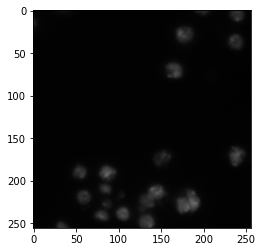

In [6]:
images = []
for i in range(len(training_data_images_full_path_image)):
    images.append(cv2.imread(training_data_images_full_path_image[i]))
plt.imshow(images[0])

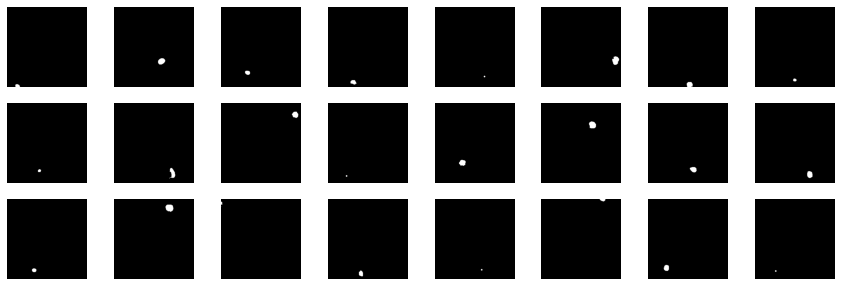

In [7]:
fig = plt.figure(figsize=(15, 5))
columns = 8
rows = 3 
for i in range(1, columns*rows +1):
    mask = cv2.imread(training_data_images_full_path_mask[0][i])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(mask)
plt.show()

It can be seen that each segmented cell nuclei is located in different masks. This is a problem because they are needed to be all in one.

## Combine all the masks of a certain image into a single one
Each mask from a medical image is combined into a single one.

In [8]:
masks_combined = []
for i in range(len(training_data_images_full_path_mask)):
    mask_single = cv2.imread(training_data_images_full_path_mask[i][0])
    for j in range(1, len(training_data_images_full_path_mask[i])):
        maskj = cv2.imread(training_data_images_full_path_mask[i][j])
        mask_single = mask_single + maskj
    masks_combined.append(mask_single)

3 different medical images


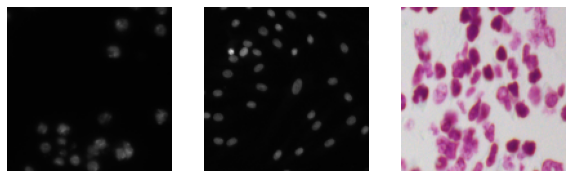

In [190]:
fig = plt.figure(figsize=(10, 12))
columns = 3
rows = 1 
print("3 different medical images")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()

3 different masks of the 3 medical images that are above


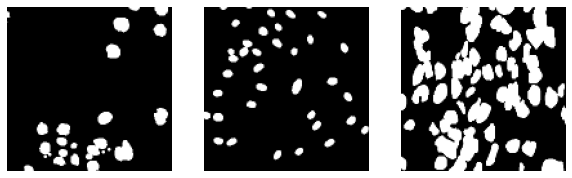

In [191]:
fig = plt.figure(figsize=(10, 12))
columns = 3
rows = 1 
print("3 different masks of the 3 medical images that are above")
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(masks_combined[i])
plt.show()

As can be seen, the masks have been combined.

## Resize images and masks
The second preprocessing step is to resize all the images and masks because the model need all the input image to have the same size. In this case, they are going to be dowsized to 128x128

In [23]:
for i in range(len(images)):
    images[i] = cv2.resize(images[i], (128, 128))
    masks_combined[i] = cv2.resize(masks_combined[i], (128, 128))

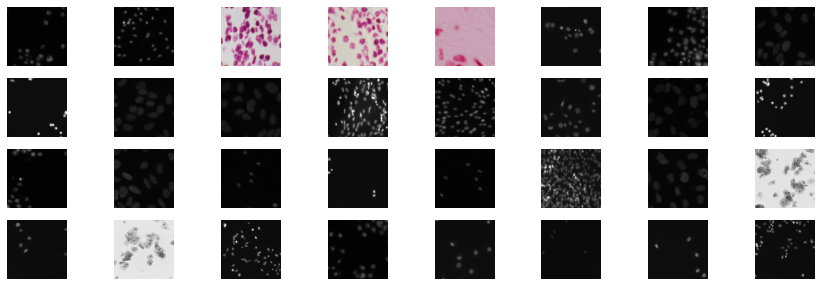

In [24]:
fig = plt.figure(figsize=(15, 5))
columns = 8
rows = 4 
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(images[i])
plt.show()

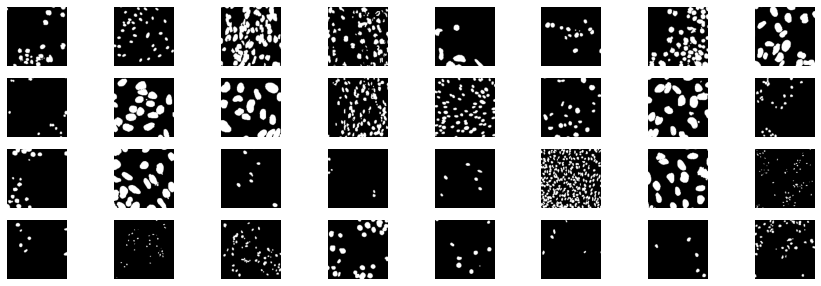

In [25]:
fig = plt.figure(figsize=(15, 5))
columns = 8
rows = 4 
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(masks_combined[i])
plt.show()

## Binarize masks
Some masks are not completely black and white, this may decrease the final accuracy enormely due to the large number of label classes. Therefore, a binarization technique is necessary.

In [26]:
masks_bw = []
for i in range(len(images)):
    gray_mask = cv2.cvtColor(masks_combined[i], cv2.COLOR_BGR2GRAY)
    (thresh, mask_bw) = cv2.threshold(gray_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)    
    masks_bw.append(mask_bw)

## Normalize images and masks
The final step is to normalize the images and masks so their pixel values are ranged between 0 and 1. This step increase the prediction accuracy.

In [166]:
images_normal = []
masks_normal = []
for i in range(len(images)): 
    images_normal.append(images[i]/255.)
    masks_normal.append(masks_bw[i]/255.)
    masks_normal[i] = np.expand_dims(masks_normal[i], axis=-1)

## Fixing
After passing the training data to the model, the model could not perform the training due to an inconsistency between the dimensions accepted by the model and those of the training images. Thefore, the dimensions of the training datas must be altered so they can fit in the model.

In [167]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
x_train = np.zeros((len(images_normal), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y_train = np.zeros((len(masks_normal), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i in range(len(images_normal)):
    x_train[i] = images_normal[i]
    y_train[i] = masks_normal[i]

Preprocessing done

# Create deep learning model

In [9]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

## Build U-Net model
U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.

Source: https://en.wikipedia.org/wiki/U-Net

In [10]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [94]:
# # Fit model
# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model_Cell_nuclei_segmentation.h5', verbose=1, save_best_only=True)
# results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

# Make predictions

In [97]:
# Load model that was saved previously
model = load_model('model_Cell_nuclei_segmentation.h5')

## Checking if model works correctly
Checking if model works correctly by predicting already known input data such as the images used for training


In [99]:
predictions_train_images = model.predict(x_train)

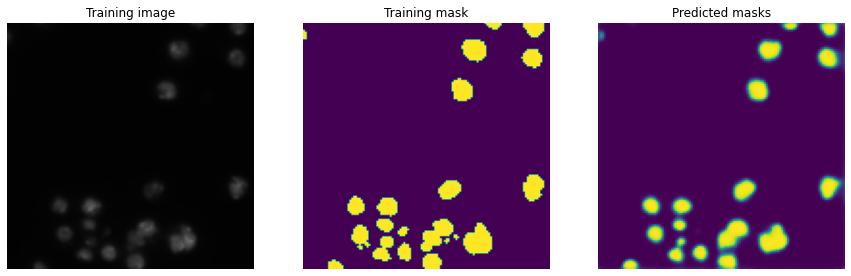

In [168]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 3, 1)
plt.title("Training image")
plt.axis('off')
plt.imshow(x_train[0])

fig.add_subplot(1, 3, 2)
plt.title("Training mask")
plt.axis('off')
plt.imshow(y_train[0])

fig.add_subplot(1, 3, 3)
plt.title("Predicted masks")
plt.axis('off')
plt.imshow(predict[0])
plt.show()

## Checking if model predicts correctly
Checking if model predicts correctly by predicting unknown input data

In [110]:
# Create paths for test images
test_data_folder_path = 'data-science-bowl-2018/stage1_test'
test_data_subfolders_paths = os.listdir(test_data_folder_path)

test_data_images_full_path = []
for i in range(len(os.listdir(test_data_folder_path))):
    final_test_image_path = os.listdir(test_data_folder_path 
                                  + "/" + 
                                  test_data_subfolders_paths[i] 
                                  + "/" + 
                                  "images")[0]
    test_data_images_full_path.append(test_data_folder_path + 
                                      "/" +
                                      test_data_subfolders_paths[i] +
                                      "/images/" +
                                      final_test_image_path)

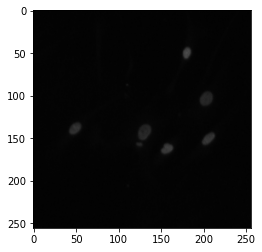

In [141]:
# Loading test images
test_images = []
for i in range(len(test_data_images_full_path)):
    test_images.append(cv2.imread(test_data_images_full_path[i]))
plt.imshow(test_images[0])

In [142]:
# Resizing and normalize
for i in range(len(test_images)):
    test_images[i] = cv2.resize(test_images[i], (128, 128))
    test_images[i] = test_images[i]/255.
    
    
# Fixing dimension compatibility
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
x_test = np.zeros((len(test_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

for i in range(len(test_images)):
    x_test[i] = test_images[i]

In [143]:
# Make predictions
predictions_test_images = model.predict(x_test)

Accuracy and other performance metrics can not be given because masks for testing were not provided, only medical images were provided. So, all that can be done were showing the masks created by the model' prediction.

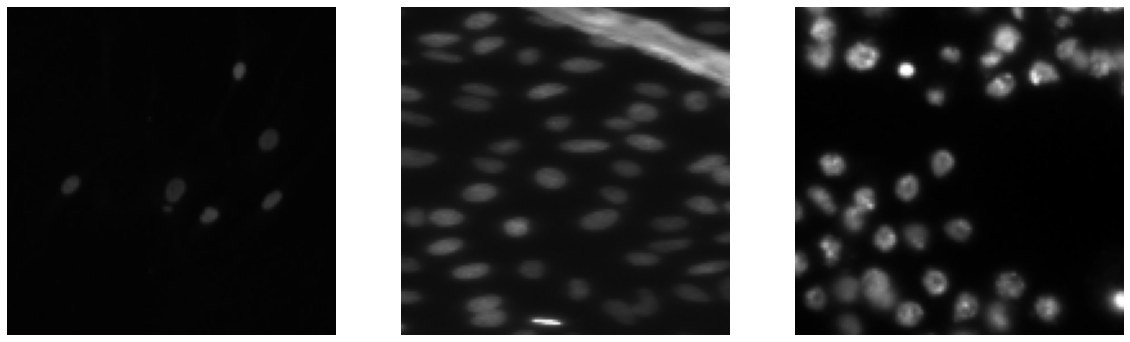

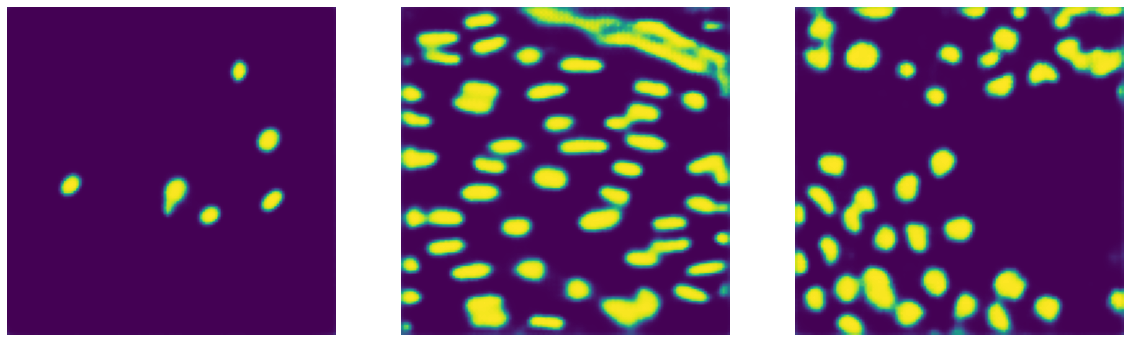

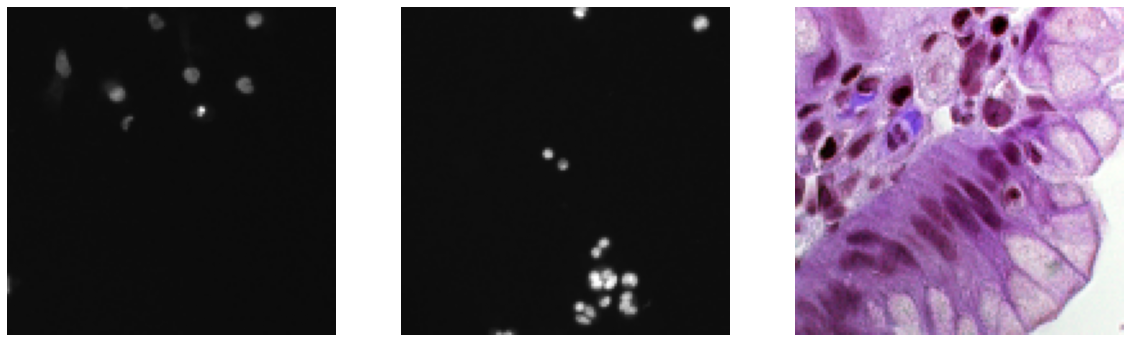

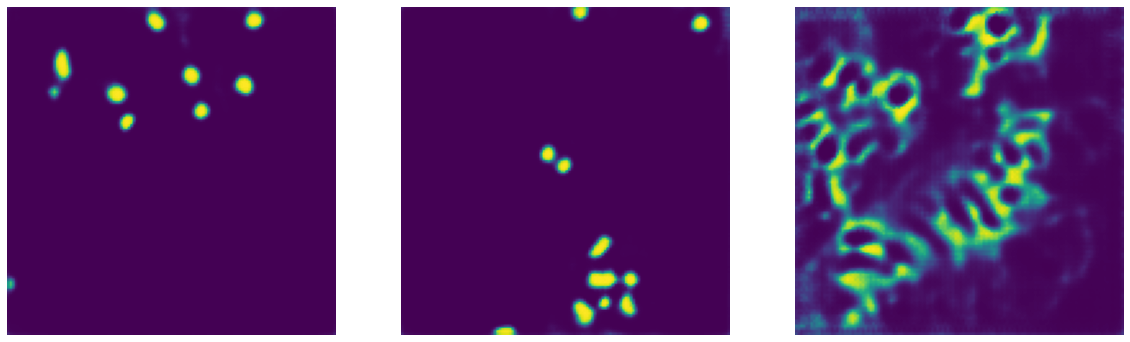

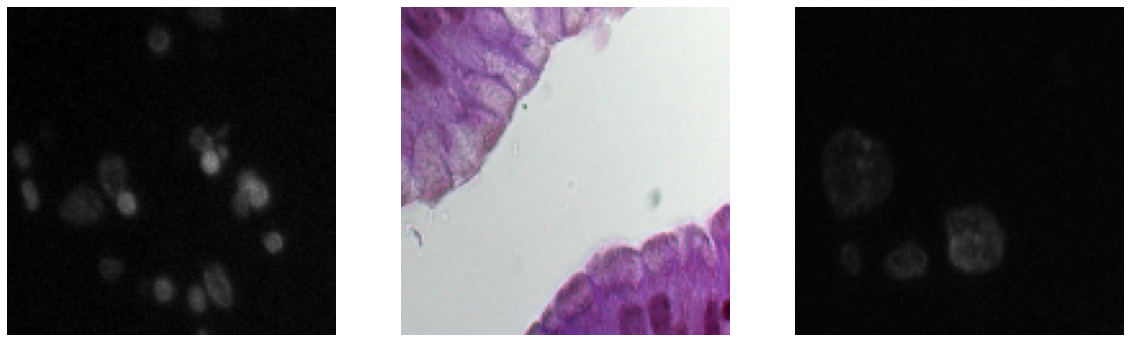

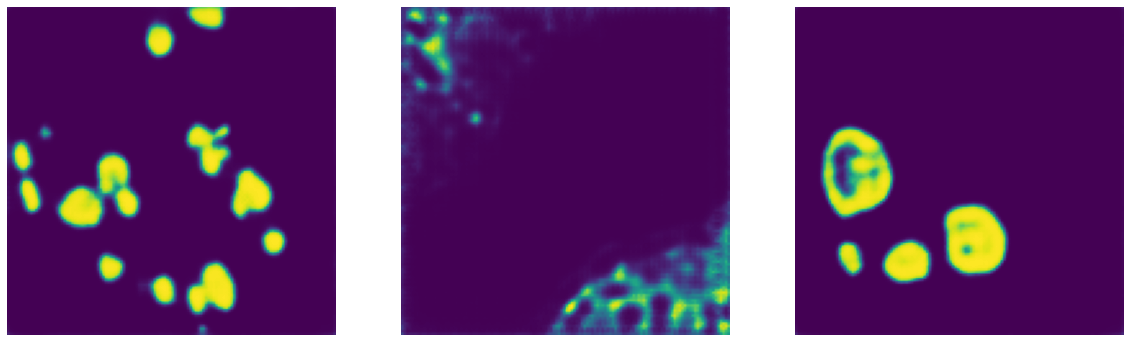

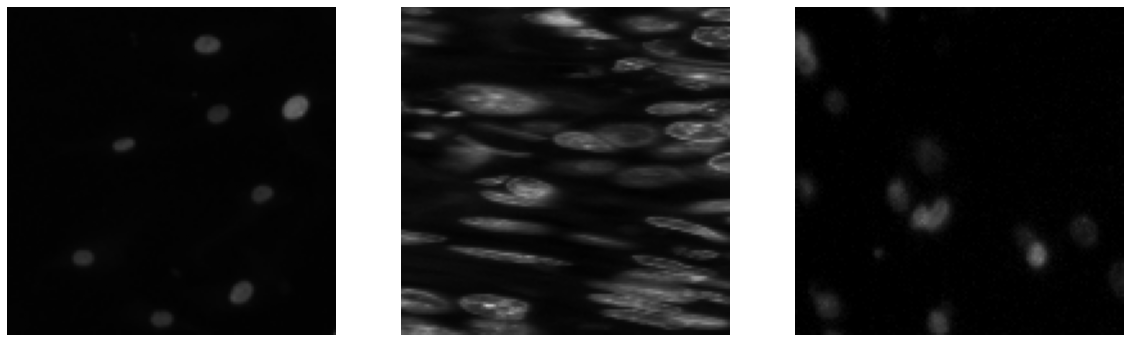

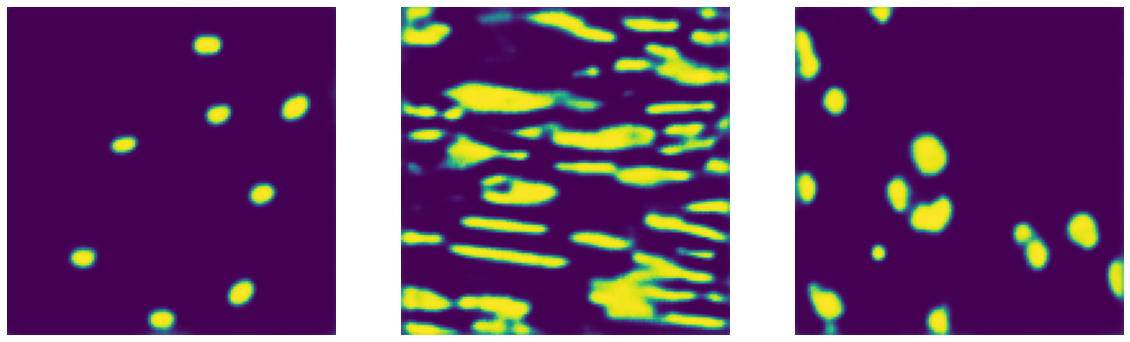

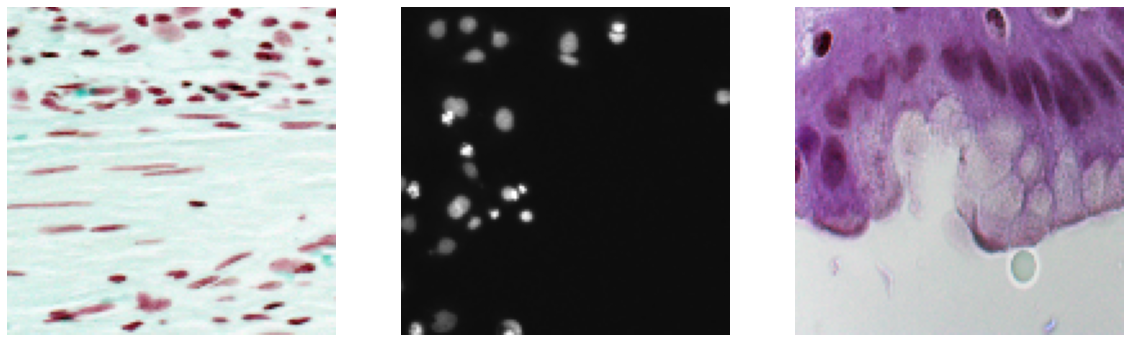

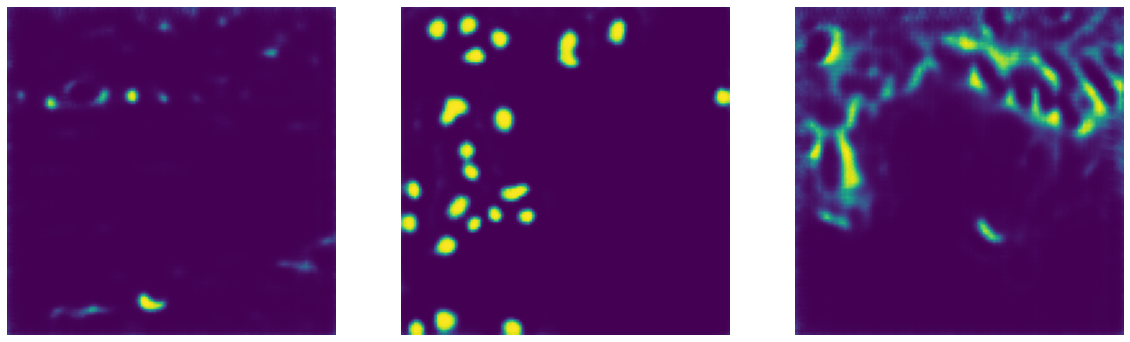

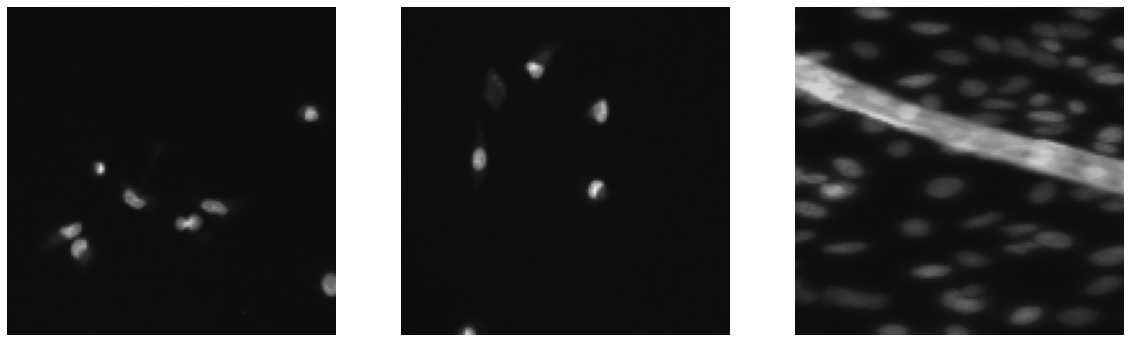

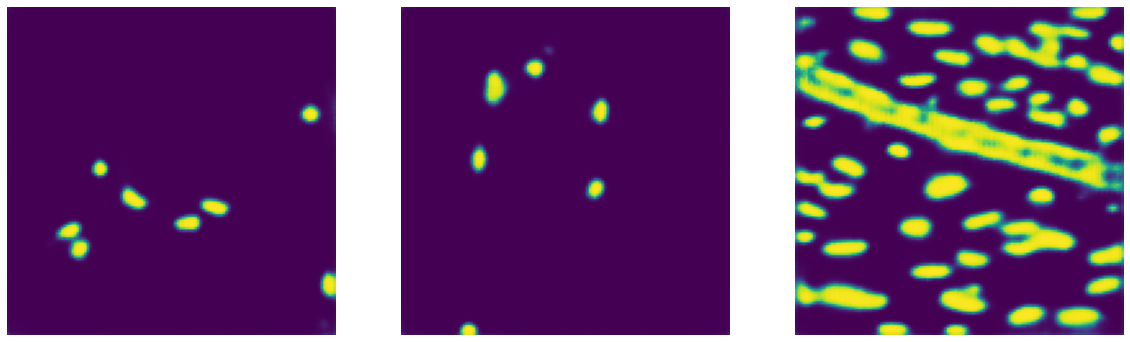

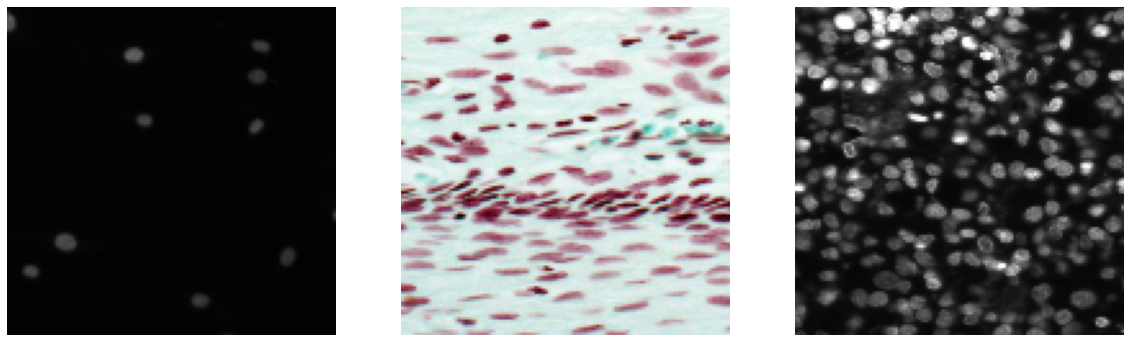

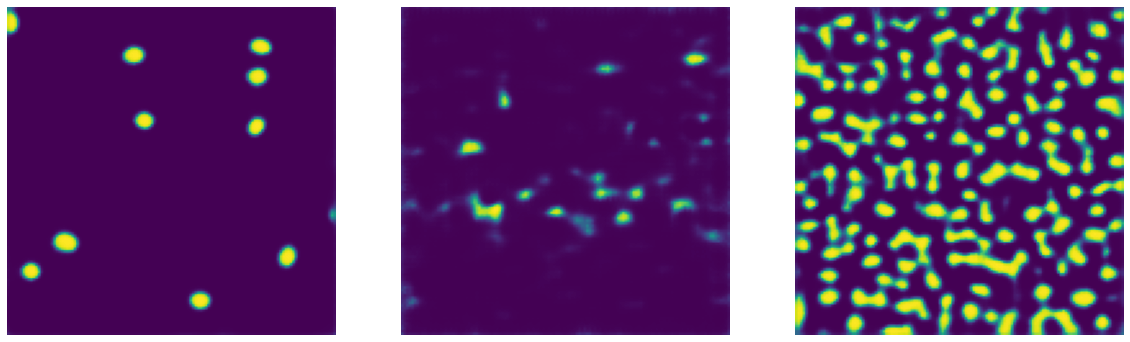

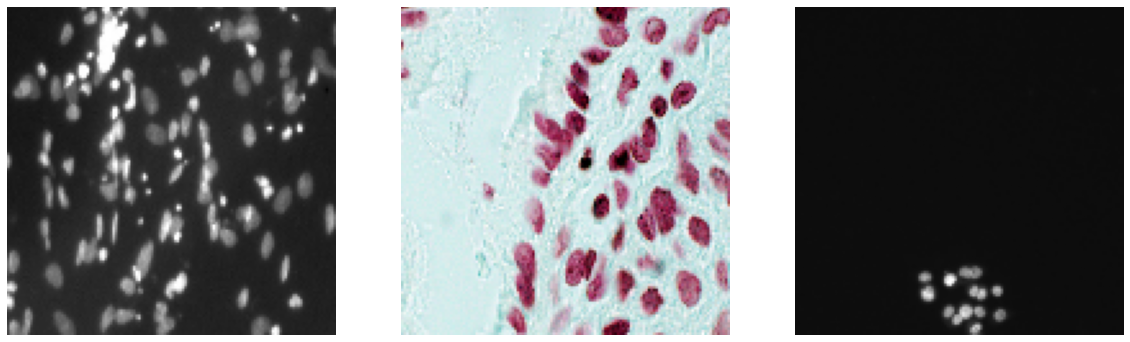

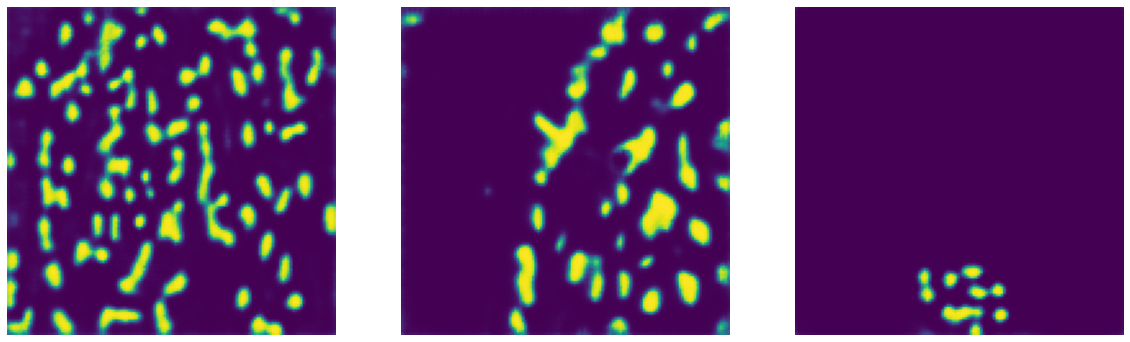

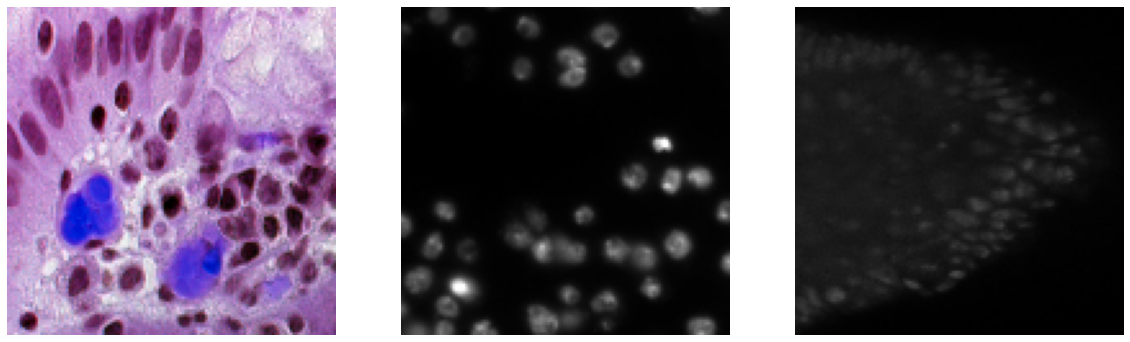

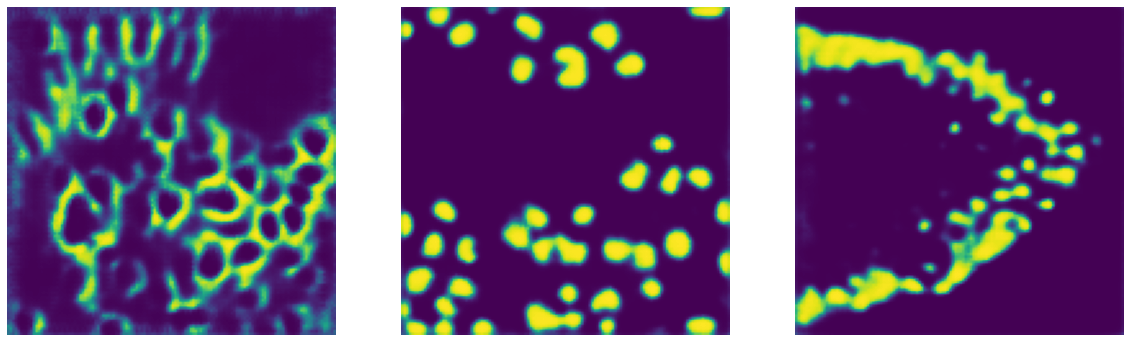

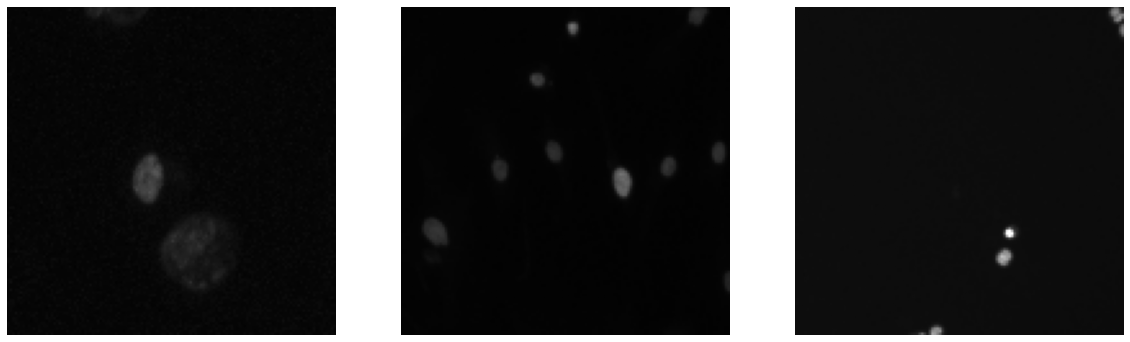

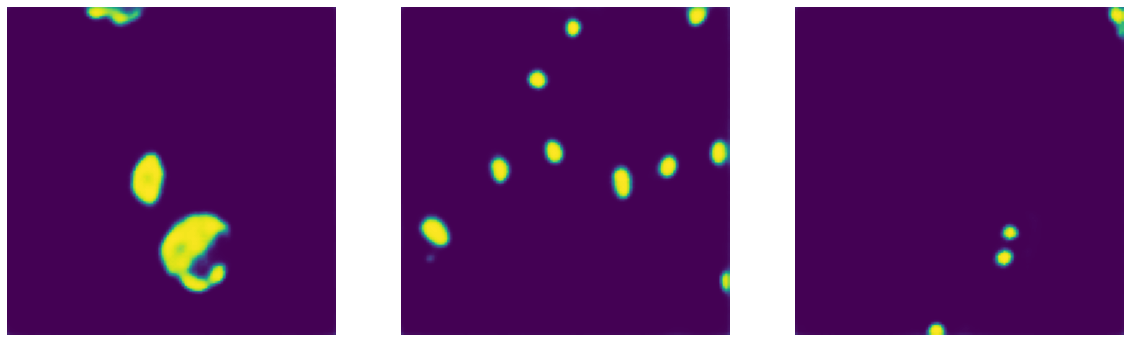

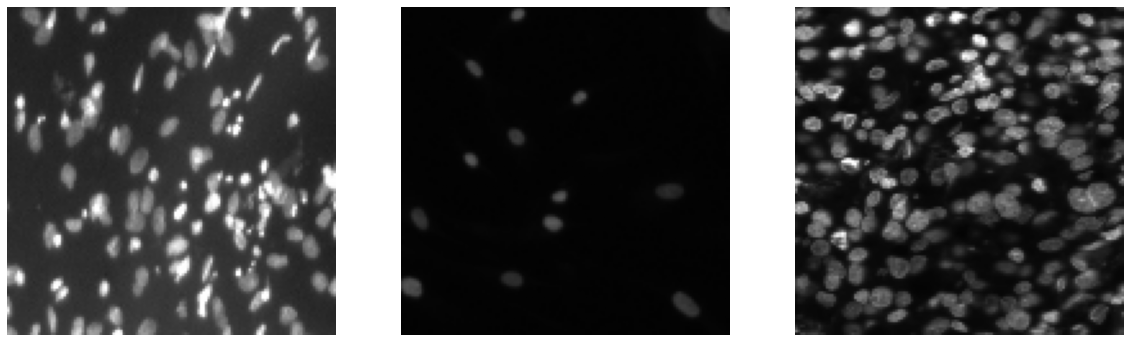

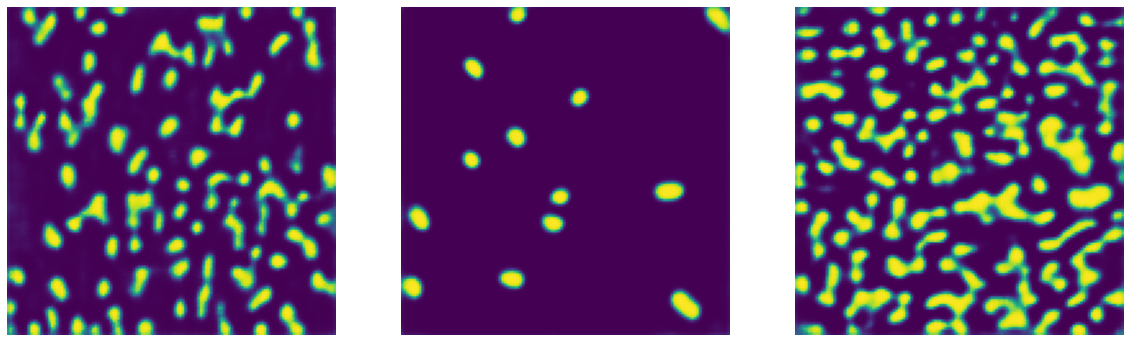

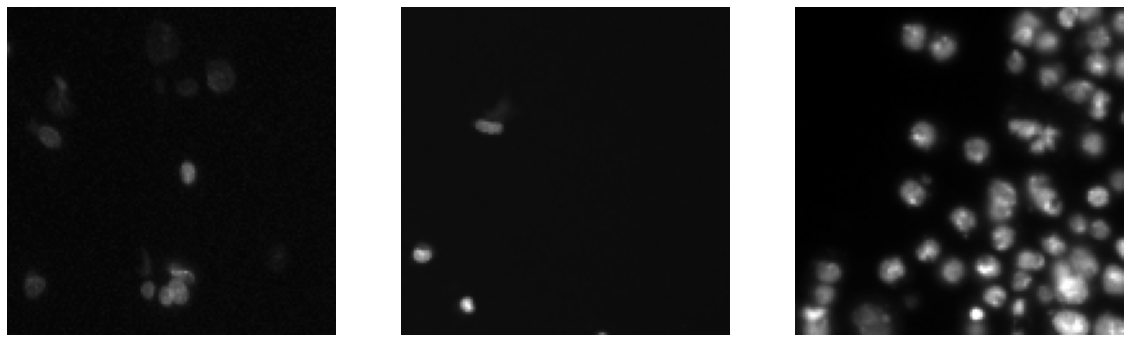

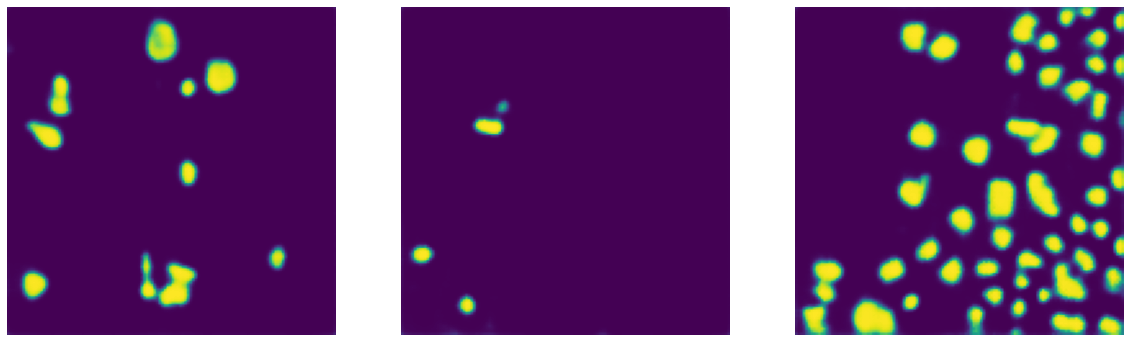

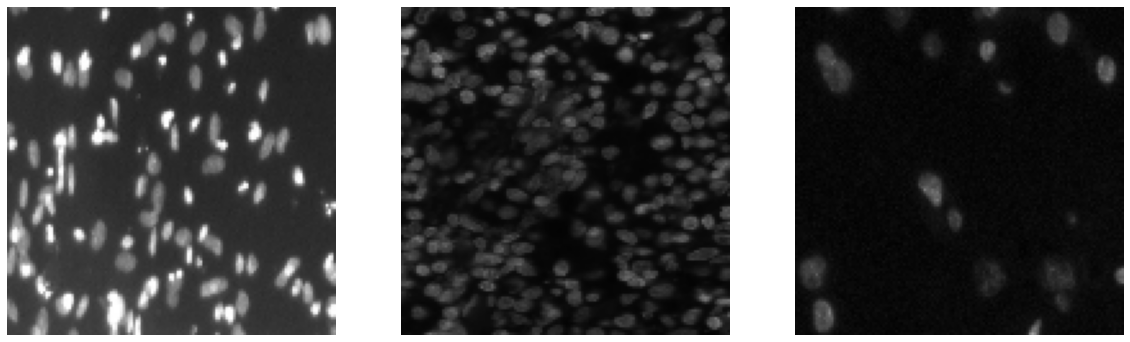

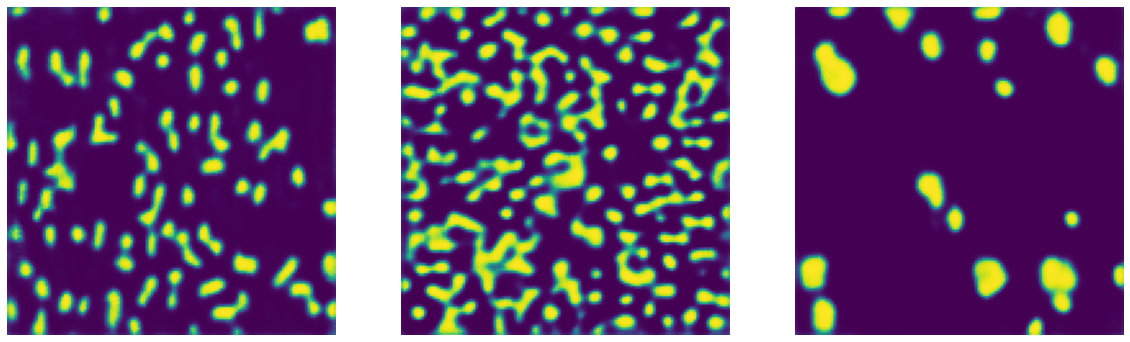

In [165]:
# Showing original test images and their respective predicted masks
columns = 3
rows = 1
for j in range(int(len(x_test)/5)):
    fig = plt.figure(figsize=(20, 20))
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(x_test[i+j*columns])
    plt.show()

    fig = plt.figure(figsize=(20, 20))
    columns = 3
    rows = 1
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(predictions_test_images[i+j*columns])
    plt.show()